# Inventory Optimization with PuLP

## Business problem

In this notebook, I tackle the **inventory optimization problem** faced by supply chain managers.  

To keep the study focused and interpretable, I start by considering a **single product (one SKU)**.  
Although this may look like a simplification, it is far from trivial:  
- Even for one product, deciding **how much and when to order** involves balancing multiple conflicting costs (purchasing, holding, shortages).  
- Lead times, demand uncertainty, and capacity constraints make the problem relevant to real-world practice.  
- Once the methodology is validated for a single SKU, it can be extended to multiple products, where the complexity grows significantly.  

In practice, a company needs to decide:  

- **How much to order** in each period (week or month).  
- **When to order**, given supplier lead times.  
- **How to balance trade-offs** between purchasing, holding, and shortage costs.  

If orders are too large, I end up with:  
- Excess inventory sitting in the warehouse.  
- Higher holding costs (e.g., storage, capital tied up, risk of obsolescence).  

If orders are too small, I risk:  
- Stockouts and shortages.  
- Lost sales, unhappy customers, and potential penalties.  

The business challenge is therefore to **find the right ordering policy** that **minimizes total costs** while satisfying customer demand as much as possible.

## Mathematical model

#### Sets and Indices

$t∈T$: time periods (e.g., weeks).

$i∈I$: products (SKUs). In this model $i=1$ (single product).

  #### Parameters (Inputs)

| Parameter | Meaning                                         | Example Values / Notes                                |
| --------- | ----------------------------------------------- | ----------------------------------------------------- |
| $c_i$     | Unit purchasing cost of product $i$             | 10\$ per unit                                         |
| $h_i$     | Holding cost per unit per period                | 10% of unit cost per period                           |
| $p_i$     | Shortage penality cost per unit                 | 50\$ per unit (estimated lost sales or penalty)       |
| $D_{i,t}$ | Forecasted demand for product $i$ in period $t$ | From "forecasts_single_sku.csv"                       |
| $L_i$     | Lead time for product $i$ (in periods)          | 2 periods (weeks)                                     |
| $C_t$     | Warehouse or budget capacity in period $t$      | 5000 units or 50,000\$ budget                         |


#### Decision Variables

$Q_i,t≥0:$ order quantity of product $i$ at period $t$.

$Ii,t≥0:$ inventory of product $i$ at the end of period $t$.

$Si,t≥0:$ shortage (unsatisfied demand) of product $i$ in period $t$. 

Note: shortages are modeled as **lost sales**, i.e., unmet demand that is not backordered to future periods.

#### Objective Function

I minimize the **total cost** over all products and time periods:  

$$
\min \sum_{i \in I} \sum_{t \in T} \big( c_i Q_{i,t} + h_i I_{i,t} + p_i S_{i,t} \big)
$$

*Intuition:* the optimization problem balances a trade-off between ordering costs, holding costs, and shortage penalties: ordering too little saves money upfront but incurs high shortage costs, while ordering too much increases holding costs; the optimal solution finds the cost-minimizing balance.

#### Constraints

**Inventory Balance Constraint**

$$
I_{i,t} = I_{i,t-1} + Q_{i,t-L_i} - D_{i,t} + S_{i,t} , \quad \forall i \in I, \; t \in T
$$  

*Intuition*:   
$I_{i,t-1}$ : inventory carried over from the previous period  
$Q_{i,t-L_i}$ : arrivals from orders placed $L_i$ periods ago  
$D_{i,t}$ : demand to be satisfied in this period  
$S_{i,t}$ :shortage, i.e. units of demand not satisfied

**Capacity / Budget Constraint**

$$
\sum_{i \in I} c_i Q_{i,t} \leq C_t, \quad \forall t \in T
$$  

*Intuition*: the total purchasing cost in each period must not exceed the available budget or capacity.

**Shortage Constraint**

$$
S_{i,t} \leq D_{i,t}, \quad \forall i \in I, \; t \in T
$$  

*Intuition*: the shortage (unmet demand) in each period cannot exceed the actual demand of that period. This prevents the model from creating “phantom shortages”.

**Inventory Capacity Constraint**

$$
I_{i,t} \leq I^{max}_{i,t}, \quad \forall i \in I, \; t \in T
$$  

*Intuition*: the inventory cannot exceed the warehouse storage capacity.This constraint prevents the optimizer from stockpiling unlimited units.

**Non-negativity Constraints**

$$
Q_{i,t} \geq 0, \quad I_{i,t} \geq 0, \quad S_{i,t} \geq 0 
\quad \forall i \in I, \; t \in T
$$  

*Intuition*: order quantities, inventory levels, and shortages cannot be negative.

## Computational model and optimization

In this section I transform the demand forecasts into an actionable ordering policy via a linear optimization model solved with PuLP's default solver (CBC).  

**Goal:** I use the demand forecasts from notebook `02_Forecasting.ipynb` to decide how much to order each period so as to **minimize total cost**:

- purchasing cost $c \cdot Q_t$,
- holding cost $h \cdot I_t$,
- shortage cost $p \cdot S_t$,

subject to the previous contraints.

I model **one SKU** (Stock Keeping Unit) over T periods with **lead time L** (orders placed now arrive after L periods). I set costs and capacity as inputs (assumptions that can later be calibrated). I clip any negative forecast to zero to avoid non-physical demand.


In [1]:
import numpy as np
import pandas as pd
from pathlib import Path
import matplotlib.pyplot as plt
import pulp
import scipy.sparse as sp
import time

In [2]:
ROOT = Path("..")
DATA_PROCESSED = ROOT / "data" / "processed"
RESULTS_FIG = ROOT / "results" / "figures"
RESULTS_OUT = ROOT / "results" / "outputs"
forecast_csv = DATA_PROCESSED / "forecasts_single_sku.csv"
demand_df = pd.read_csv(forecast_csv)

#### Handling Negative Forecasts  

In the demand forecasts, I occasionally obtain **negative values**.  
This can happen due to refunds, returns, or model extrapolation errors.  

However, in the **inventory optimization model**, demand cannot be negative:  
- It is not physically possible to "sell" a negative number of units.  
- Optimization models rely on constraints and balances that assume all flows (orders, inventory, shortages) are **non-negative quantities**.  
- A negative demand would break the inventory balance equation and lead to nonsensical results (e.g., creating stock out of nowhere).  

In [3]:
full_demand = demand_df["demand"].clip(lower=0).to_numpy()

#### Planning parameters (to be tuned to the business)

In [4]:
c = 10.0        # unit purchase cost
h_rate = 0.1    # holding as % of unit cost per period
h = h_rate * c  # holding cost per unit per period
p = 50.0        # shortage penalty per unit
L = 2           # lead time (weeks)
I0 = 0.0        # initial inventory (units)
horizon = 26    # rolling horizon length in weeks

C = 200000.0    # max budget per period in currency units (c * Q_t <= C)
I_max = 40000.0 # maximum warehouse capacity (units)

T_total = len(full_demand)
t_start = 0
I_current = I0
results = []

#### PuLP's model

In [5]:
T_window = min(horizon, T_total - t_start)
demand = full_demand[:T_window]

# Create LP model
m = pulp.LpProblem("single_sku_inventory", pulp.LpMinimize)
Q = pulp.LpVariable.dicts("Q", range(T_window), lowBound=0, cat="Continuous")
I = pulp.LpVariable.dicts("I", range(T_window), lowBound=0, cat="Continuous")
S = pulp.LpVariable.dicts("S", range(T_window), lowBound=0, cat="Continuous")

# Constraints
for t in range(T_window):
    arrivals = Q[t - L] if t - L >= 0 else 0.0
    prev_I = I_current if t == 0 else I[t - 1]
    m += I[t] == prev_I + arrivals - demand[t] + S[t], f"balance[{t}]"
    m += c * Q[t] <= C, f"budget[{t}]"
    m += S[t] <= demand[t], f"shortage_cap[{t}]"
    m += I[t] <= I_max, f"capacity[{t}]" 

# Objective: minimize total cost (purchase + holding + shortage)
m += pulp.lpSum(c*Q[t] + h*I[t] + p*S[t] for t in range(T_window))

# Solve the model
status = m.solve()

# Save results
results = []
I_current = 0.0  # initial inventory

for t in range(T_window):
    arrivals = Q[t-L].value() if t >= L else 0.0           # Quantity that arrives this week (considering lead time)
    available = I_current + arrivals                       # Available stock this week
    shortage = max(0, demand[t] - available)
    inv = max(0, available - demand[t])
    
    results.append({
        "week": t,
        "Q": Q[t].value(),
        "available": available,
        "I": inv,
        "S": shortage
    })
    
    I_current = inv

results_df = pd.DataFrame(results)
results_df['forecast_demand'] = full_demand[:len(results_df)]
results_df = results_df.round({"Q": 2, "available": 2, "I": 2, "S": 2, "forecast_demand": 2})

print(results_df.to_string(index=False))
results_df.to_csv(RESULTS_OUT / "ordering_policy_next_26_weeks.csv", index=False)
print("Results saved to:", RESULTS_OUT / "ordering_policy_next_26_weeks.csv")

 week        Q  available        I        S  forecast_demand
    0 17322.09       0.00     0.00 19321.57         19321.57
    1 20000.00       0.00     0.00  1234.61          1234.61
    2   428.82   17322.09  1607.17     0.00         15714.91
    3 14067.62   21607.17     0.00     0.00         21607.17
    4 20000.00     428.82     0.00     0.00           428.82
    5 20000.00   14067.62  8432.59     0.00          5635.04
    6 17809.31   28432.59 28432.59     0.00             0.00
    7 20000.00   48432.59     0.00     0.00         48432.59
    8 20000.00   17809.31  6308.73     0.00         11500.58
    9 20000.00   26308.73 21286.35     0.00          5022.38
   10 20000.00   41286.35 40000.00     0.00          1286.35
   11 16272.04   60000.00 12343.20     0.00         47656.80
   12 20000.00   32343.20     0.00 41574.38         73917.58
   13 20000.00   16272.04 13037.75     0.00          3234.29
   14 20000.00   33037.75 30033.11     0.00          3004.65
   15 20000.00   50033.1

## Results interpretation and Lineplot

The results show, for each week `t`:
- `Q` Quantity ordered in the period (units).
- `available`: Inventory available at the start of the period plus any arrivals from previous orders considering lead time.  
- `I`: Inventory at the end of the period (units).  
- `S`: Shortage or unsatisfied demand in the period (units of lost sales).  
- `forecast_demand`: Predicted demand for the period.

**Observations:**

- In the first weeks, you may notice that the order quantity (Q) is **less than the maximum budget** even though inventory is zero. This is due to the **lead time**: orders placed in week 0 arrive only after 2 weeks. The optimizer chooses a lower order to **minimize total cost**, balancing holding costs and shortage penalties in future periods.  
- Shortages in the first weeks are inevitable because inventory has not yet arrived.  
- The **last two rows** of the table correspond to periods beyond the rolling horizon (or forecast window) and may include partial orders or leftover inventory. They **should not be considered** for operational decision-making—they only reflect the model's boundary effect at the end of the horizon.


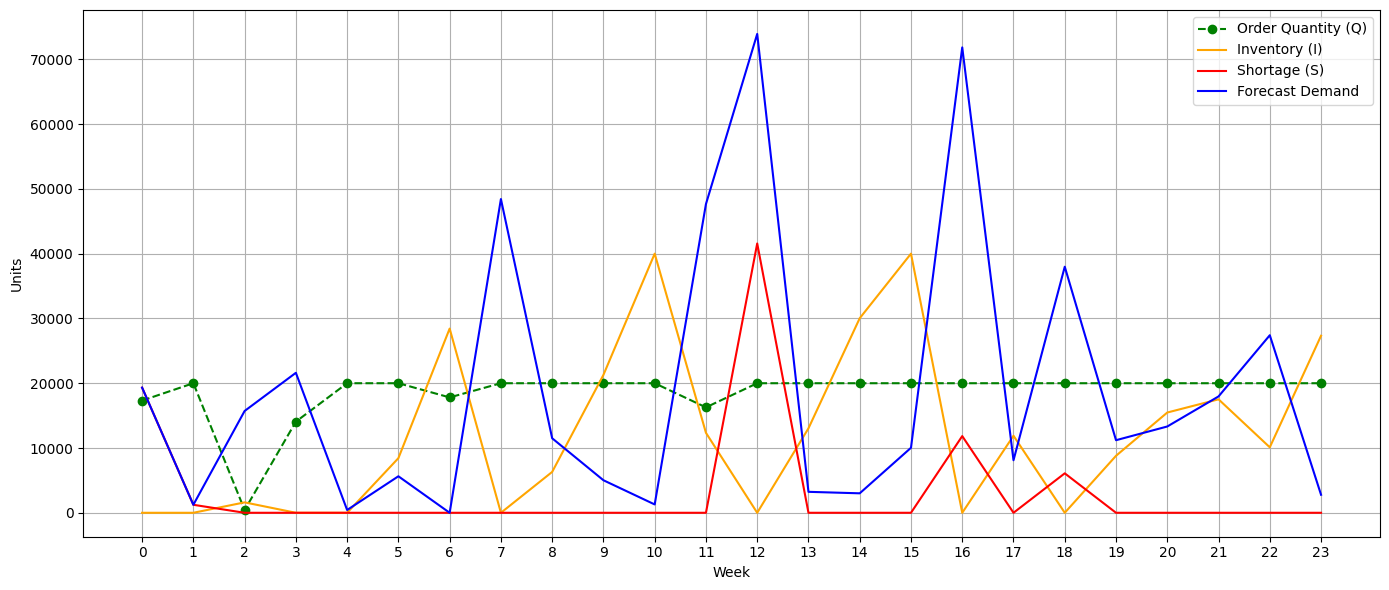

In [6]:
plot_df = results_df.iloc[:-2]     # Exclude the last two weeks

plt.figure(figsize=(14,6))

plt.plot(plot_df["week"], plot_df["Q"], label="Order Quantity (Q)", color="green", linestyle="--", marker="o")
plt.plot(plot_df["week"], plot_df["I"], label="Inventory (I)", color="orange")
plt.plot(plot_df["week"], plot_df["S"], label="Shortage (S)", color="red")
plt.plot(plot_df["week"], plot_df["forecast_demand"], label="Forecast Demand", color="blue")

plt.xlabel("Week")
plt.ylabel("Units")
plt.legend()
plt.grid(True)

plt.xticks(plot_df["week"])

plt.tight_layout()
plt.savefig(RESULTS_FIG / "inventory_optimization_example.png", dpi=300)
plt.show()

## Future Improvements

If I were to extend this work in the future, some possibilities include:

- **Optimizing multiple SKUs at once:** handle several products together, considering shared budget or warehouse constraints.  
- **Dynamic lead times:** account for variability or uncertainty in delivery times instead of assuming a fixed lead time.  
- **Rolling horizon updates:** recalculate orders periodically as new demand forecasts become available.  
- **Service level targets:** add constraints to guarantee a minimum level of stock availability for important products.
- **More realistic costs:** include volume discounts, fixed ordering costs, or time-varying holding costs.  
- **Integration with real systems:** connect the model output to ERP or inventory management tools for practical application.  

These improvements would make the model closer to real-world supply chain decision-making.